In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from mpl_toolkits.mplot3d import Axes3D

In [15]:
df = pd.read_csv('./csv/preprocessed_data_simple.csv')
df.head()

,Group,Rt_scale_IKI-SD,Rt_scale_IRI-SD,Rt_long_scale_IKI-SD,Rt_long_scale_IRI-SD,Rt_arpeggio_IKI-SD,Rt_arpeggio_IRI-SD,Lt_scale_IKI-SD,Lt_scale_IRI-SD,Lt_long_scale_IKI-SD,Lt_long_scale_IRI-SD,Lt_arpeggio_IKI-SD,Lt_arpeggio_IRI-SD,handedness,affected side
0,1,13.229921,28.898811,13.311980,39.062791,15.424398,43.541499,13.630298,31.908667,13.465412,39.938112,16.358171,40.739545,R,NaN
1,1,12.973927,31.402664,12.947017,54.441392,16.330051,45.511880,30.340508,28.444453,14.654740,58.183404,16.548132,27.776093,R,NaN
2,1,13.557577,28.322600,11.066986,25.212559,15.888496,44.515929,14.732778,25.661814,11.653787,29.018465,21.112888,47.075235,R,NaN
3,1,14.773290,30.408687,16.464423,35.699352,14.930320,49.281032,16.963380,29.648825,17.913393,40.423535,16.687300,35.095249,R,NaN
4,1,15.166748,22.041914,12.792190,30.024507,11.296934,27.286541,14.566124,24.018085,12.947909,37.861518,12.329798,18.891626,R,NaN


In [16]:
# 全ての演奏関連特徴量の多重共線性チェック
performance_features = [
    # 右手の特徴量（標準偏差）
    'Rt_scale_IKI-SD', 'Rt_scale_IRI-SD', 'Rt_long_scale_IKI-SD',
    'Rt_long_scale_IRI-SD', 'Rt_arpeggio_IKI-SD', 'Rt_arpeggio_IRI-SD',
    # 左手の特徴量（標準偏差）
    'Lt_scale_IKI-SD', 'Lt_scale_IRI-SD', 'Lt_long_scale_IKI-SD',
    'Lt_long_scale_IRI-SD', 'Lt_arpeggio_IKI-SD', 'Lt_arpeggio_IRI-SD'
]

X = df[performance_features]

In [17]:
# 相関行列の計算
correlation_matrix = X.corr()

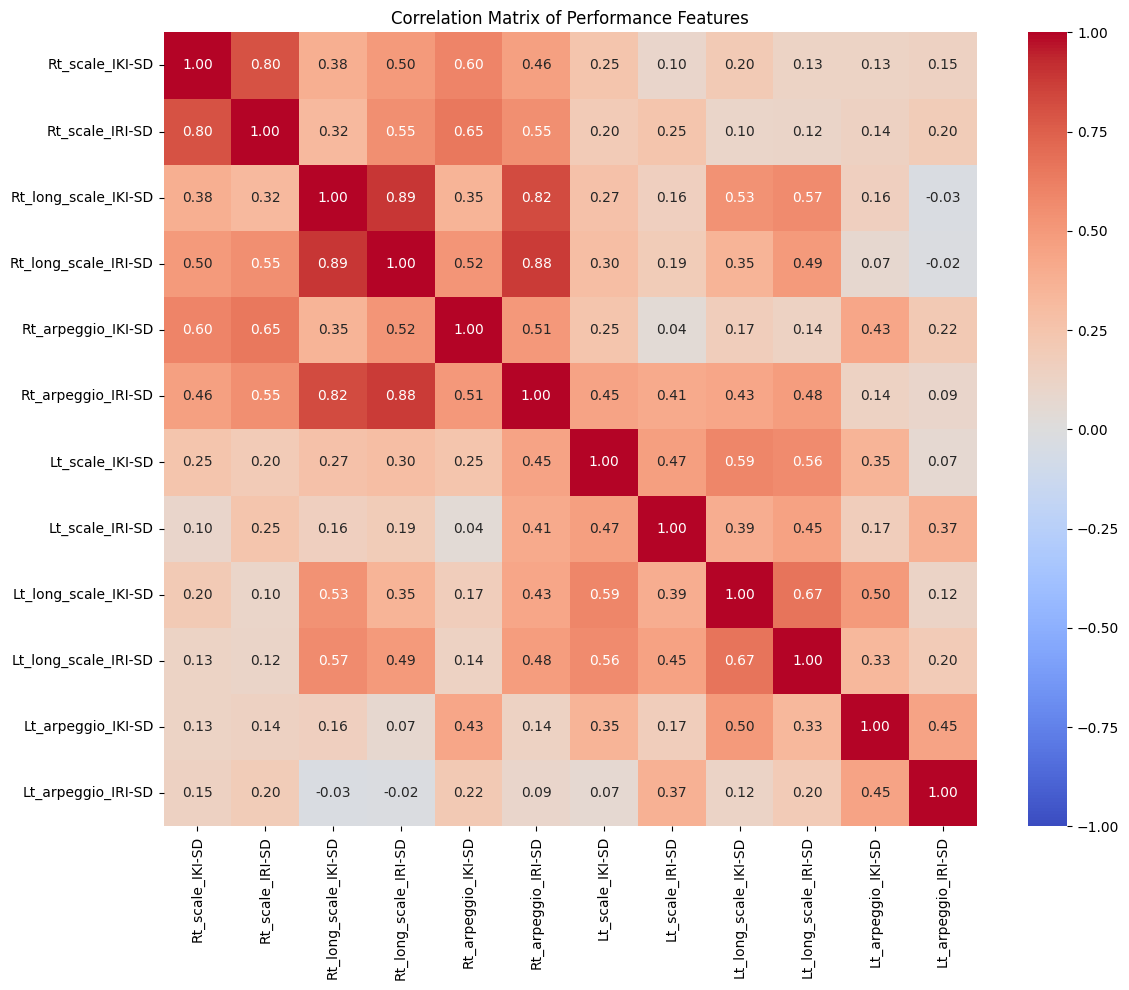

In [18]:
# ヒートマップの作成
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # 相関係数を表示
            cmap='coolwarm',  # 色のパレット
            center=0,  # 0を中心とした色付け
            fmt='.2f',  # 小数点2桁まで表示
            vmin=-1, vmax=1)  # スケールの範囲
plt.title('Correlation Matrix of Performance Features')
plt.tight_layout()
plt.show()

In [19]:

# VIF計算
X = df[performance_features]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIFの結果を確認（値が大きい順にソート）
print(vif_data.sort_values('VIF', ascending=False))

                 Feature        VIF
5     Rt_arpeggio_IRI-SD  57.495814
3   Rt_long_scale_IRI-SD  49.017714
10    Lt_arpeggio_IKI-SD  46.421518
9   Lt_long_scale_IRI-SD  40.238445
4     Rt_arpeggio_IKI-SD  38.068421
7        Lt_scale_IRI-SD  34.049233
8   Lt_long_scale_IKI-SD  33.654548
0        Rt_scale_IKI-SD  31.865319
6        Lt_scale_IKI-SD  31.573734
2   Rt_long_scale_IKI-SD  26.077019
1        Rt_scale_IRI-SD  23.900980
11    Lt_arpeggio_IRI-SD  21.599375


# 相関行列とVIFの結果の解釈

## 相関行列の解釈

### 1. 高い相関
- **Rt_scale_IKI-SDとRt_scale_IRI-SD**: 相関が **0.80** と高く、右手のスケール演奏における打鍵と離鍵のタイミングが密接に関連。
- **Rt_long_scale_IKI-SDとRt_long_scale_IRI-SD**: 相関が **0.89** と非常に高く、長いスケール演奏でも同様の傾向。
- **Rt_arpeggio_IKI-SDとRt_arpeggio_IRI-SD**: 相関が **0.51** と中程度で、アルペジオ演奏においても関連がある。

### 2. 左右の手の比較
- 右手と左手の同じタスク間での相関は比較的低く、左右の手が **独立して動作** している可能性。

### 3. タスク間の相関
- **右手のRt_long_scale_IKI-SDとRt_arpeggio_IKI-SD** の間で **0.52** と中程度の相関が見られ、異なる演奏タスク間での **共通のリズムパターン** の存在を示唆。

---

## VIFの解釈

### 1. 高いVIF値
- **Rt_arpeggio_IRI-SDやRt_long_scale_IRI-SD**: VIFが **非常に高く、多重共線性の問題** を示唆。他の特徴量と情報が重複している可能性。

### 2. 多重共線性の影響
- **高いVIF値を持つ特徴量** は、モデルの解釈を難しくし、予測の不安定性を引き起こす可能性。
- これらの特徴量を **削除する** か、**主成分分析（PCA）などで次元削減** を行うことを検討。

---

## 結論
1. **右手のスケールと長いスケール演奏における打鍵と離鍵のタイミングは密接に関連** しており、演奏の一貫性を示している可能性。
2. **多重共線性の影響を軽減するために、VIFが高い特徴量の処理を検討** することが重要。
3. **左右の手の動作が独立** していることを考慮し、分析を進めることが可能。


# PCA（主成分分析）

## PCAを行う理由

### 1. 次元削減
- **多重共線性の影響を軽減** し、データの主要な変動要因を特定するため。

### 2. 解釈の簡素化
- 高次元データを **少数の主成分に変換** し、解釈を容易にする。

### 3. ノイズの除去
- **重要でない特徴を排除** し、データのノイズを減らす。

---

## PCAの適用が適切な理由

### 1. 多重共線性の存在
- **VIFが高い特徴量が多く**、PCAによって次元削減を行うことで、これらの影響を軽減できる。

### 2. データの構造理解
- **主成分を通じて、データの構造やパターンを理解** しやすくなる。

In [20]:
# データの準備
df_clean = df.dropna(subset=performance_features)  # 欠損値のある行を削除
X_scaled = StandardScaler().fit_transform(df_clean[performance_features])

In [21]:
# PCAの実行
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

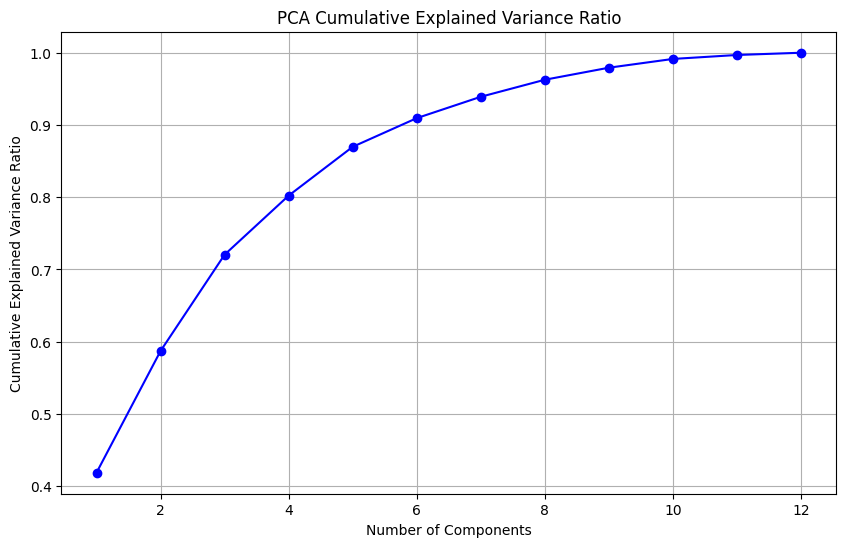


PCA explained variance ratio:
PC1: 0.418 (41.8%)
PC2: 0.169 (16.9%)
PC3: 0.133 (13.3%)
PC4: 0.082 (8.2%)
PC5: 0.068 (6.8%)
PC6: 0.040 (4.0%)
PC7: 0.030 (3.0%)
PC8: 0.024 (2.4%)
PC9: 0.017 (1.7%)
PC10: 0.012 (1.2%)


In [22]:
# 寄与率の可視化
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.title('PCA Cumulative Explained Variance Ratio')
plt.show()

# 各主成分の寄与率
print("\nPCA explained variance ratio:")
for i, ratio in enumerate(pca.explained_variance_ratio_[:10]):  # 上位10成分
    print(f"PC{i+1}: {ratio:.3f} ({ratio*100:.1f}%)")

# 主成分の負荷量（各特徴量の寄与）
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
    index=performance_features
)

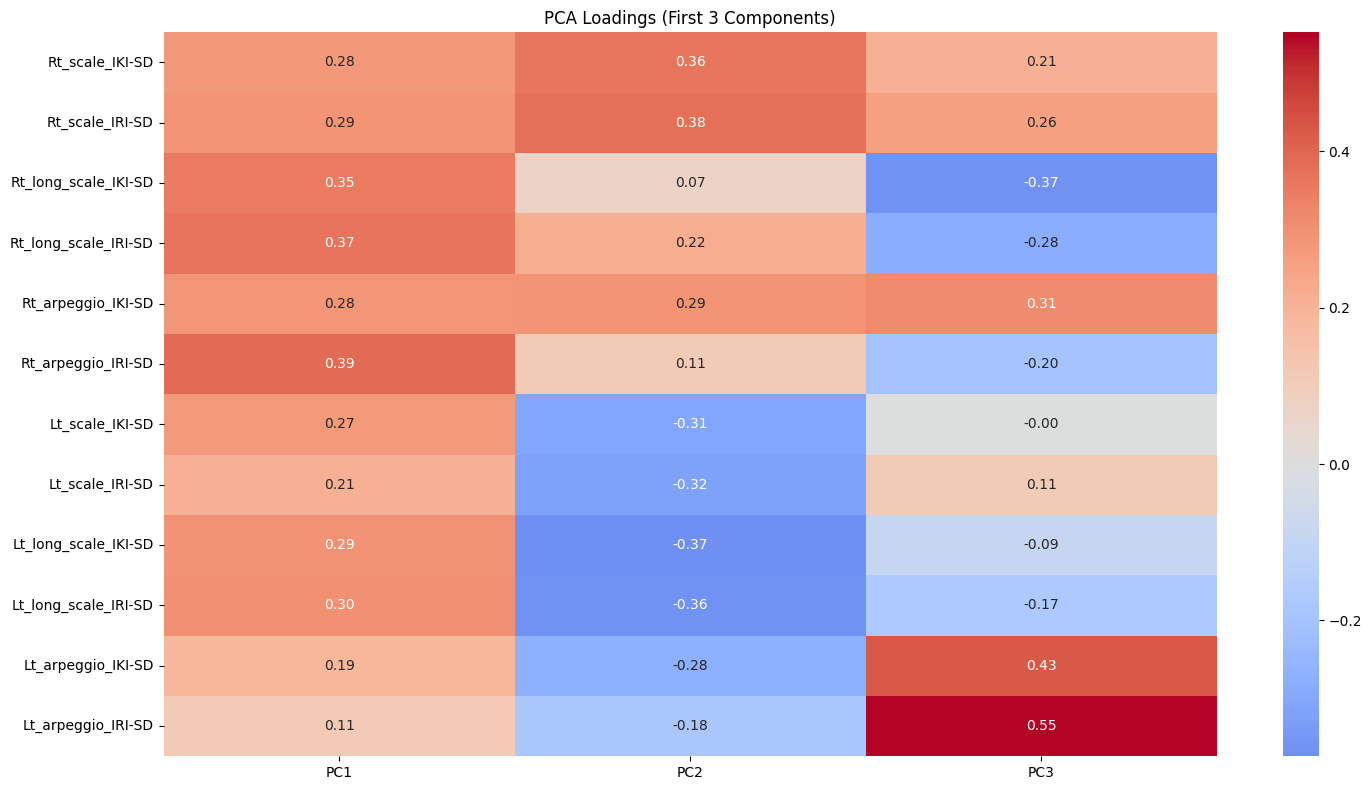

In [23]:
# 上位3主成分の負荷量を可視化
plt.figure(figsize=(15, 8))
sns.heatmap(loadings.iloc[:, :3], 
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f')
plt.title('PCA Loadings (First 3 Components)')
plt.tight_layout()
plt.show()

# PCAの結果の考察

## 主成分の解釈

### PC1（第一主成分）
- **高い負荷量**: Rt_arpeggio_IRI-SD, Rt_long_scale_IRI-SD, Rt_scale_IRI-SD など
- **解釈**: 右手の演奏における **打鍵と離鍵のタイミング** が主に影響している可能性がある。これは、演奏の **速度やリズムの一貫性** を反映しているかもしれない。

### PC2（第二主成分）
- **高い負荷量**: Lt_scale_IRI-SD, Lt_long_scale_IRI-SD など（負の負荷量）
- **解釈**: **左手の演奏に関連する特徴** が強調されており、**左右の手の非対称性や独立性** を示唆している可能性がある。

### PC3（第三主成分）
- **高い負荷量**: Lt_arpeggio_IRI-SD
- **解釈**: **左手のアルペジオ演奏における離鍵のタイミング** が強調されており、特定の演奏技術や表現力に関連しているかもしれない。

---

## 全体の考察

### 1. 多重共線性の軽減
- **PCAにより、相関の高い特徴量を少数の主成分に集約** することで、多重共線性の影響を軽減できている。

### 2. データの構造理解
- 主成分を通じて、**演奏の速度、リズム、左右の手の非対称性** など、データの主要な変動要因を理解する手助けとなる。

### 3. 次のステップ
- **主成分を用いた群間の違いの分析が可能**。例えば、
  - **主成分を用いたクラスタリング**
  - **分類モデルの構築**
- **この結果を基に、演奏能力の指標を作成** したり、**ジストニアの影響を評価するさらなる分析** を行うことも考えられる。

In [24]:
# PCAスコアをデータフレームとして取得
pca_scores = pd.DataFrame(
    X_pca[:, :3],  # 最初の3つの主成分のみ
    columns=['PC1', 'PC2', 'PC3'],
    index=df_clean.index  # 元のインデックスを保持
)

# 元のデータフレームとPCAスコアを結合
df_with_pca = pd.concat([df[['Group']], pca_scores], axis=1)
df_with_pca['Group'] = df_with_pca['Group'].map({1: 'HP', 2: 'DP'})


In [25]:
# 色の設定
palette = {'HP': '#F8766D', 'DP': '#00BFC4'}

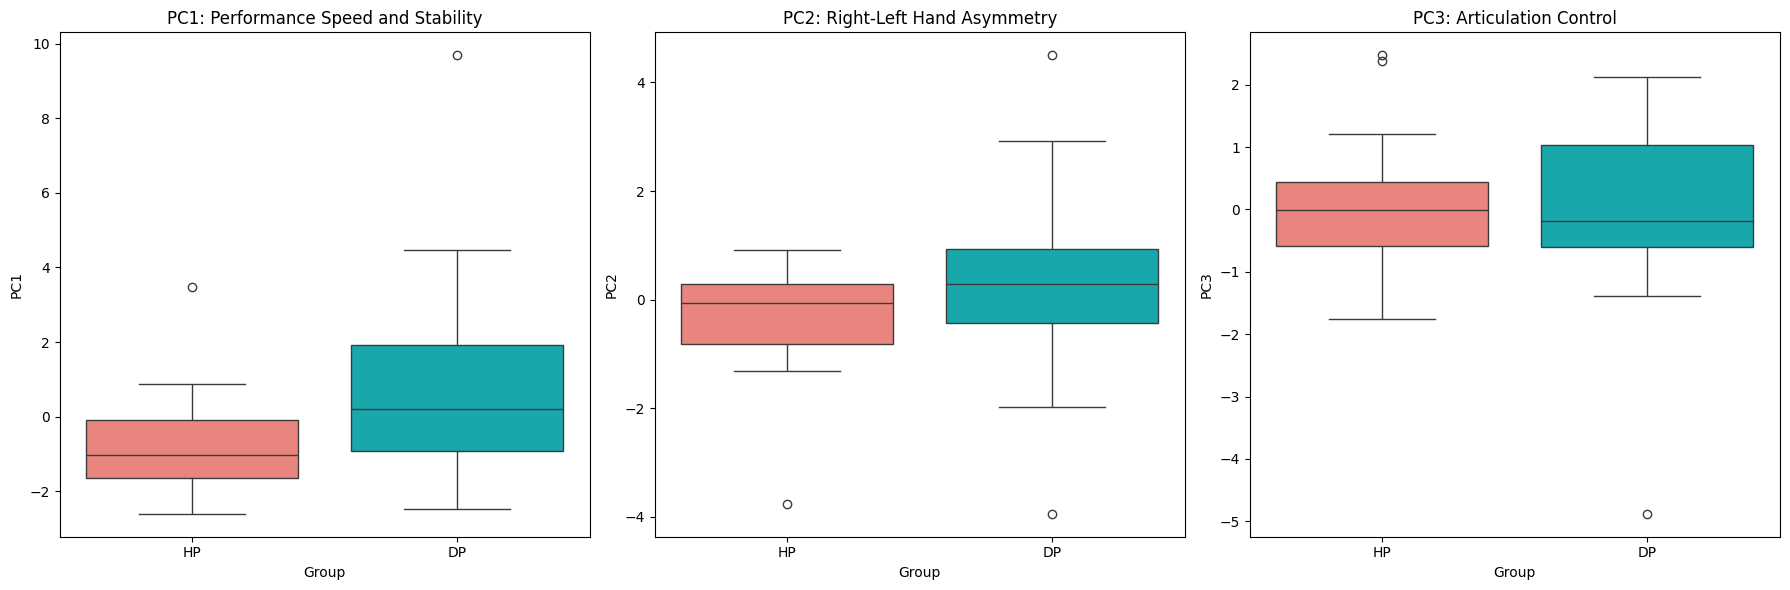

In [26]:
# 箱ひげ図
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PC1
sns.boxplot(data=df_with_pca, x='Group', y='PC1', hue='Group', ax=axes[0], 
            palette=palette, legend=False)
axes[0].set_title('PC1: Performance Speed and Stability')

# PC2
sns.boxplot(data=df_with_pca, x='Group', y='PC2', hue='Group', ax=axes[1], 
            palette=palette, legend=False)
axes[1].set_title('PC2: Right-Left Hand Asymmetry')

# PC3
sns.boxplot(data=df_with_pca, x='Group', y='PC3', hue='Group', ax=axes[2], 
            palette=palette, legend=False)
axes[2].set_title('PC3: Articulation Control')

plt.tight_layout()
plt.show()

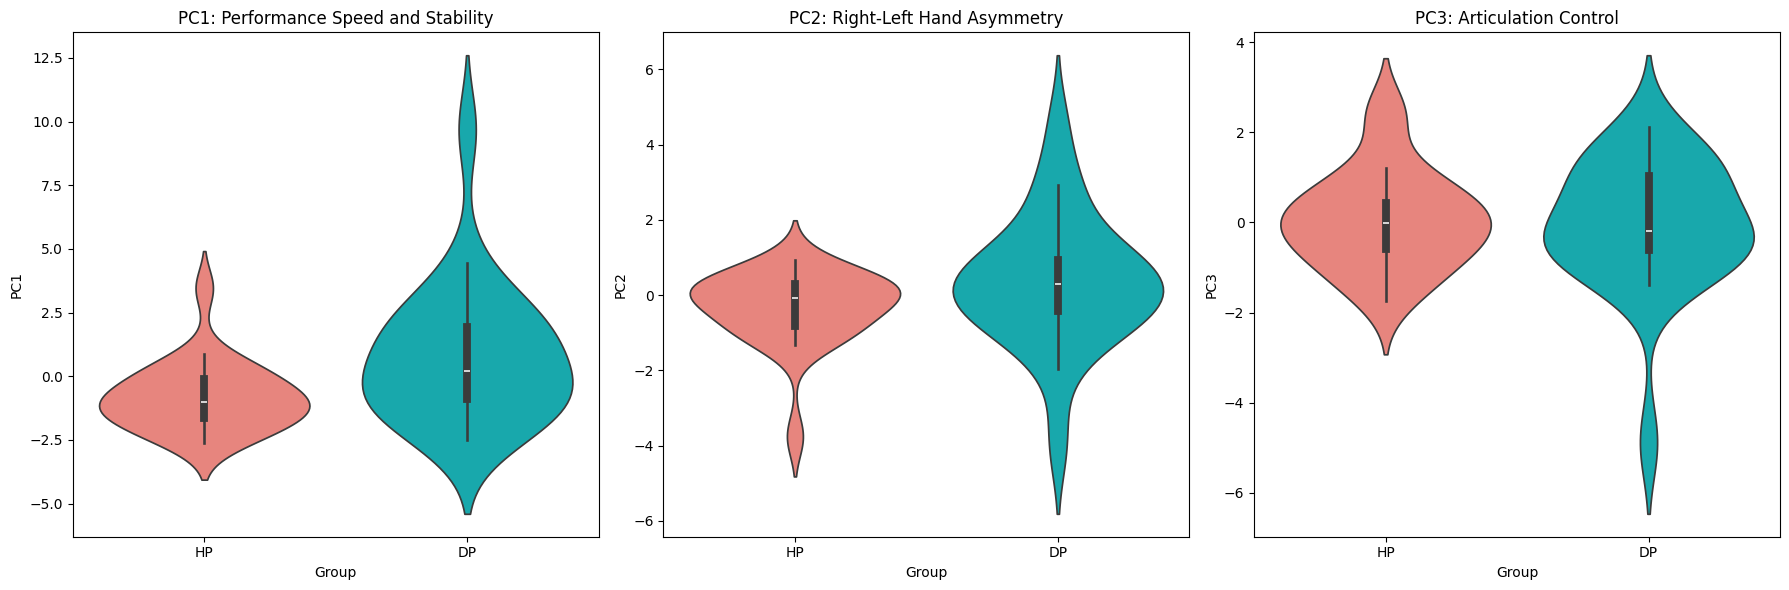

In [ ]:
# バイオリンプロット
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PC1
sns.violinplot(data=df_with_pca, x='Group', y='PC1', hue='Group', ax=axes[0], 
               palette=palette, legend=False)
axes[0].set_title('PC1: Performance Speed and Stability')

# PC2
sns.violinplot(data=df_with_pca, x='Group', y='PC2', hue='Group', ax=axes[1], 
               palette=palette, legend=False)
axes[1].set_title('PC2: Right-Left Hand Asymmetry')

# PC3
sns.violinplot(data=df_with_pca, x='Group', y='PC3', hue='Group', ax=axes[2], 
               palette=palette, legend=False)
axes[2].set_title('PC3: Articulation Control')

plt.tight_layout()
plt.show()

In [28]:

def run_statistical_tests(df, variable):
    # グループごとのデータ取得
    hp = df[df['Group'] == 'HP'][variable]
    dp = df[df['Group'] == 'DP'][variable]
    
    # 1. Shapiro-Wilk test for normality
    _, p_normal_hp = shapiro(hp)
    _, p_normal_dp = shapiro(dp)
    normal_dist = (p_normal_hp > 0.05) and (p_normal_dp > 0.05)
    
    # 2. Levene's test for equality of variances
    _, p_var = levene(hp, dp)
    equal_var = p_var > 0.05
    
    # 3. Group comparison
    if normal_dist:
        # If normal distribution, use t-test
        stat, p_value = ttest_ind(hp, dp, equal_var=equal_var)
        test_name = "t-test"
    else:
        # If not normal, use Mann-Whitney U test
        stat, p_value = mannwhitneyu(hp, dp, alternative='two-sided')
        test_name = "Mann-Whitney U test"
    
    # Print results
    print(f"\nResults for {variable}:")
    print(f"Normality test p-values: HP: {p_normal_hp:.3f}, DP: {p_normal_dp:.3f}")
    print(f"Equal variance test p-value: {p_var:.3f}")
    print(f"Group comparison ({test_name}) p-value: {p_value:.3f}")

# Run tests for each PC
for pc in ['PC1', 'PC2', 'PC3']:
    run_statistical_tests(df_with_pca, pc)


Results for PC1:
Normality test p-values: HP: 0.022, DP: 0.005
Equal variance test p-value: 0.042
Group comparison (Mann-Whitney U test) p-value: 0.022

Results for PC2:
Normality test p-values: HP: 0.001, DP: 0.325
Equal variance test p-value: 0.074
Group comparison (Mann-Whitney U test) p-value: 0.108

Results for PC3:
Normality test p-values: HP: 0.373, DP: 0.007
Equal variance test p-value: 0.482
Group comparison (Mann-Whitney U test) p-value: 0.953


In [29]:
# 主成分間の相関行列を計算
correlation_matrix = pca_scores.corr()

# 相関行列を表示
print("Correlation matrix of principal components:")
print(correlation_matrix)

Correlation matrix of principal components:
              PC1           PC2           PC3
PC1  1.000000e+00 -4.390120e-16  1.738275e-16
PC2 -4.390120e-16  1.000000e+00  4.139129e-16
PC3  1.738275e-16  4.139129e-16  1.000000e+00


# 結果の解釈と考察

## PC1
- **正規性検定**: HP・DPともに p < 0.05 → **正規分布に従わない**
- **等分散性検定**: p = 0.042 → **分散が等しくない可能性**
- **群間比較**: Mann-Whitney U検定の p = 0.022 → **統計的に有意な差**
- **考察**: **演奏の速度や安定性** において健常者群とジストニア群の違いを示唆。

## PC2
- **正規性検定**: HPは p = 0.001（非正規）、DPは p = 0.325（正規）
- **等分散性検定**: p = 0.074 → **分散が等しい可能性**
- **群間比較**: p = 0.108 → **有意な差なし**
- **考察**: 左右の手の非対称性に **ジストニアの影響は強くない可能性**。

## PC3
- **正規性検定**: HPは p = 0.373（正規）、DPは p = 0.007（非正規）
- **等分散性検定**: p = 0.482 → **分散が等しい可能性**
- **群間比較**: p = 0.953 → **有意な差なし**
- **考察**: **アーティキュレーションコントロール** にはジストニアの影響がない可能性。

---

# 全体の考察
- **PC1の有意差** → **演奏の速度・安定性における群間の違いを示唆**
- **PC2・PC3の非有意差** → **左右の手の非対称性やアーティキュレーションへの影響は小さい**
- **次のステップ**: **PC1を基に詳細な分析** や他の変数との関連を探る。

---

# 多重検定補正の必要性
- **目的**: 偽陽性（Type I error）のリスクを抑える
- **影響**: p値が大きくなり、有意性が失われる可能性
- **判断基準**:
  - **偽陽性を避ける場合** → Benjamini-Hochberg法などの補正を考慮
  - **探索的分析の場合** → 補正せずに結果を解釈する選択もあり

---

# 主成分の独立性の確認
- **PCAでは主成分は数学的に直交（独立）**
- **相関行列の確認**:
  - **PC1-PC2, PC1-PC3, PC2-PC3 の相関係数はほぼ 0**
  - **主成分は互いに独立**
- **結論**:
  - **主成分の独立性により、多重検定補正の必要性は低い可能性**
  - 研究の目的やデータの特性に応じて補正の要否を判断

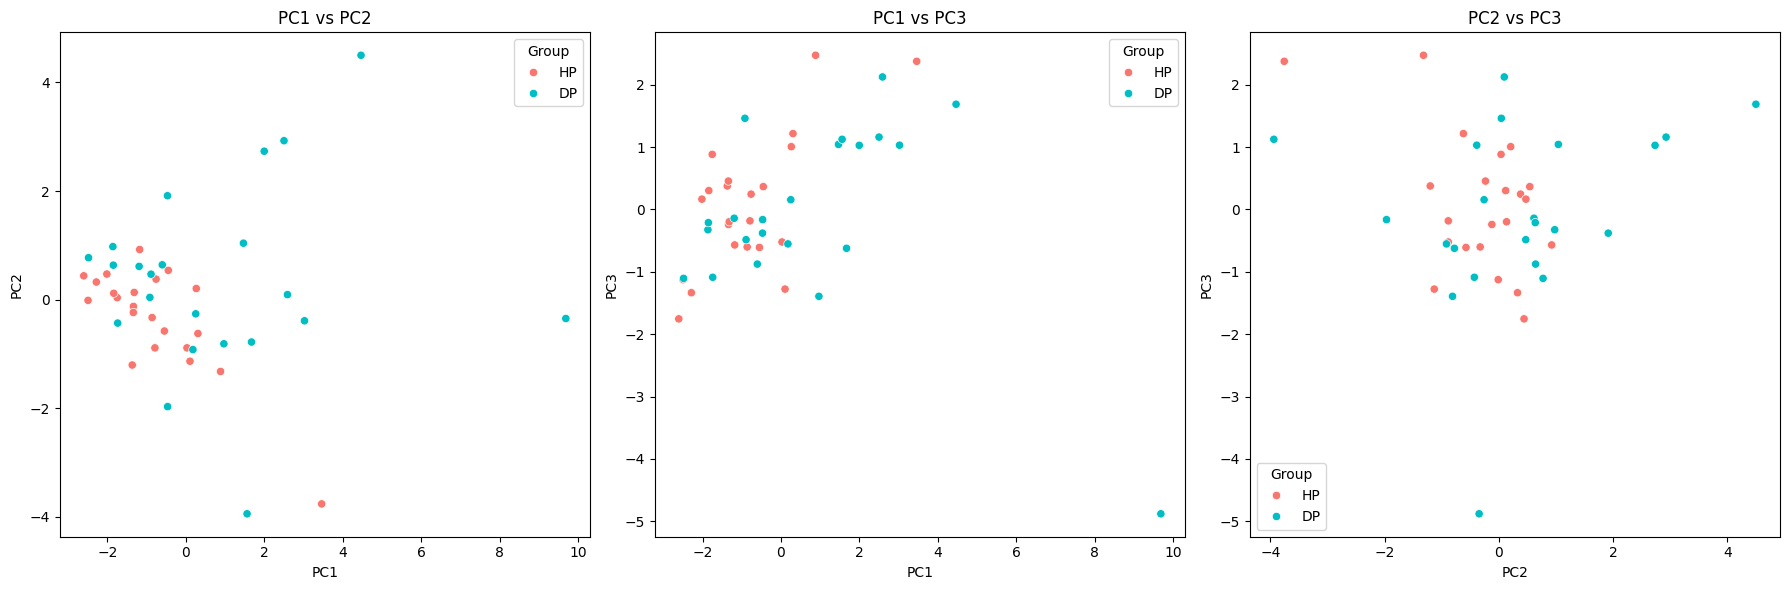

In [30]:
# PCAの可視化
# プロットの設定
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PC1 vs PC2
sns.scatterplot(data=df_with_pca, x='PC1', y='PC2', hue='Group', palette=palette, ax=axes[0])
axes[0].set_title('PC1 vs PC2')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# PC1 vs PC3
sns.scatterplot(data=df_with_pca, x='PC1', y='PC3', hue='Group', palette=palette, ax=axes[1])
axes[1].set_title('PC1 vs PC3')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC3')

# PC2 vs PC3
sns.scatterplot(data=df_with_pca, x='PC2', y='PC3', hue='Group', palette=palette, ax=axes[2])
axes[2].set_title('PC2 vs PC3')
axes[2].set_xlabel('PC2')
axes[2].set_ylabel('PC3')

plt.tight_layout()
plt.show()

/Users/sajimakazuaki/work/tokimura/.venv/lib/python3.11/site-packages/matplotlib/collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


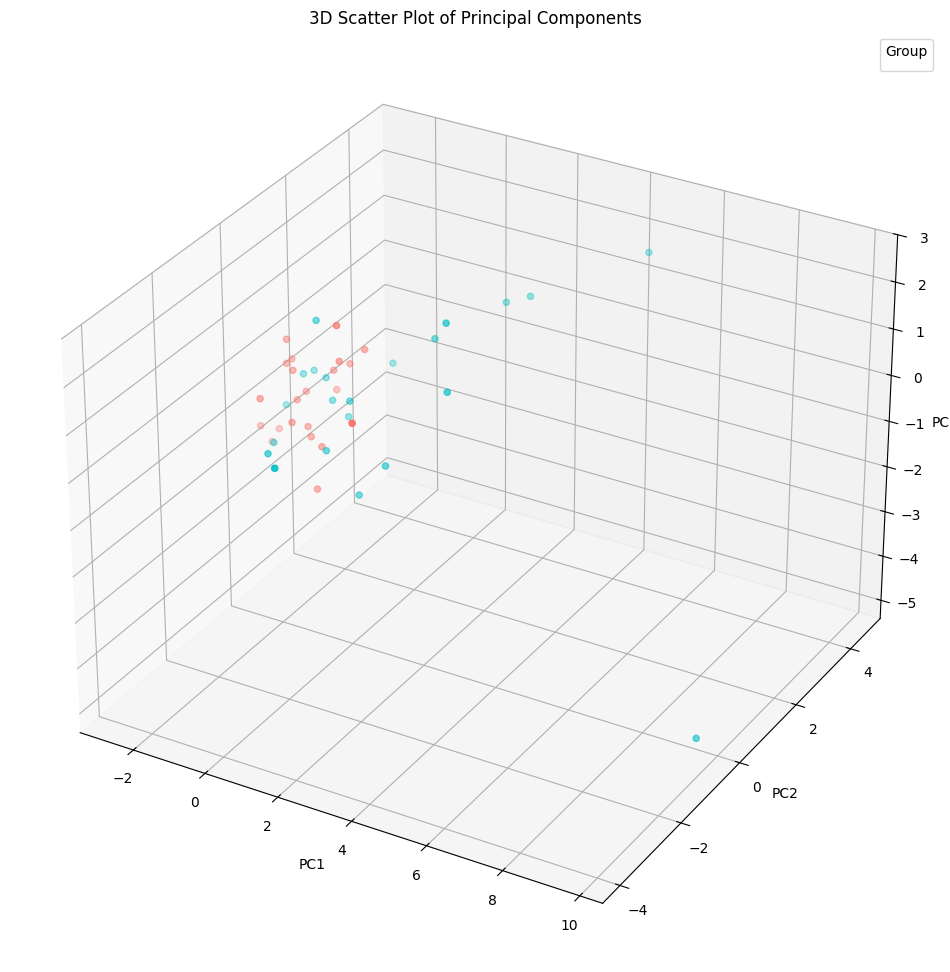

In [31]:
# 3Dプロットの設定
fig = plt.figure(figsize=(12, 100))
ax = fig.add_subplot(111, projection='3d')

# 3D散布図
scatter = ax.scatter(
    df_with_pca['PC1'], df_with_pca['PC2'], df_with_pca['PC3'],
    c=df_with_pca['Group'].map({'HP': '#F8766D', 'DP': '#00BFC4'}),
    label=df_with_pca['Group']
)

# 軸ラベルとタイトル
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of Principal Components')

# 凡例
handles, labels = scatter.legend_elements()
ax.legend(handles, ['HP', 'DP'], title="Group", loc="upper right")

plt.show()